In [ ]:
#%%

# Step 1: load the dataset
import numpy as np
import pandas as pd

data = pd.read_csv("disney_movies_total_gross.csv", parse_dates=['release_date'])
print(data)

                         movie_title release_date      genre mpaa_rating  \
0    Snow White and the Seven Dwarfs   1937-12-21    Musical           G   
1                          Pinocchio   1940-02-09  Adventure           G   
2                           Fantasia   1940-11-13    Musical           G   
3                  Song of the South   1946-11-12  Adventure           G   
4                         Cinderella   1950-02-15      Drama           G   
..                               ...          ...        ...         ...   
574         The Light Between Oceans   2016-09-02      Drama       PG-13   
575                   Queen of Katwe   2016-09-23      Drama          PG   
576                   Doctor Strange   2016-11-04  Adventure       PG-13   
577                            Moana   2016-11-23  Adventure          PG   
578     Rogue One: A Star Wars Story   2016-12-16  Adventure       PG-13   

     total_gross  inflation_adjusted_gross  
0      184925485                5228953251

In [ ]:
#%%

# Step 2: top grossing films
data.sort_values(["inflation_adjusted_gross"], ascending=False)
print(data.head(10))

                       movie_title release_date      genre mpaa_rating  \
0  Snow White and the Seven Dwarfs   1937-12-21    Musical           G   
1                        Pinocchio   1940-02-09  Adventure           G   
2                         Fantasia   1940-11-13    Musical           G   
3                Song of the South   1946-11-12  Adventure           G   
4                       Cinderella   1950-02-15      Drama           G   
5     20,000 Leagues Under the Sea   1954-12-23  Adventure         NaN   
6               Lady and the Tramp   1955-06-22      Drama           G   
7                  Sleeping Beauty   1959-01-29      Drama         NaN   
8                   101 Dalmatians   1961-01-25     Comedy           G   
9      The Absent Minded Professor   1961-03-16     Comedy         NaN   

   total_gross  inflation_adjusted_gross  
0    184925485                5228953251  
1     84300000                2188229052  
2     83320000                2187090808  
3     6500000

In [ ]:
#%%

# Step 3: genre trends
data['release_year'] = data['release_date'].dt.year
group = data.groupby(['genre', 'release_year'], as_index=True)
#print(group.head())
genre_yearly = group[['total_gross', 'inflation_adjusted_gross']].sum().reset_index()
print(genre_yearly.head(10))

    genre  release_year  total_gross  inflation_adjusted_gross
0  Action          1981            0                         0
1  Action          1982     26918576                  77184895
2  Action          1988     35155392                  72107034
3  Action          1990    118499177                 236717544
4  Action          1991     57849873                 115837145
5  Action          1992     29028000                  58965304
6  Action          1993     43887107                  89364314
7  Action          1994     57541746                 118637388
8  Action          1995    126075107                 244324853
9  Action          1996    270562192                 515510525


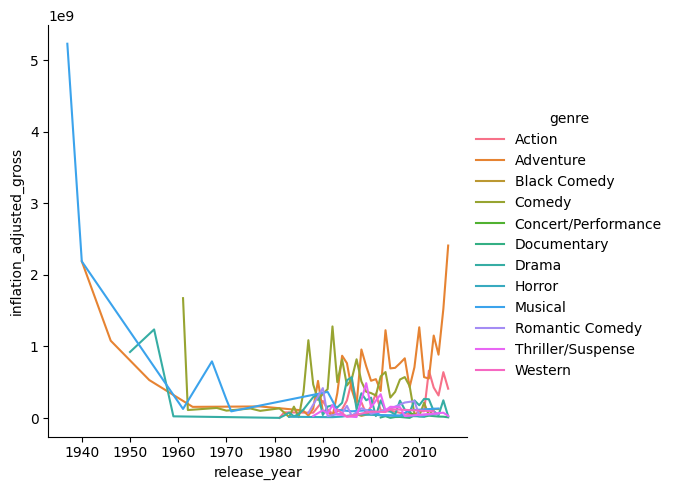

In [ ]:
#%%

# Step 4: plotting the trends of genre over the years
import seaborn as sns
sns.relplot(genre_yearly, x='release_year', y='inflation_adjusted_gross', kind='line', hue='genre')

In [ ]:
# %%

# Step 5: Prepare dummy variables for a linear regression model
genre_dummies = pd.get_dummies(data['genre'], drop_first=True)
print(genre_dummies.head())

   Adventure  Black Comedy  Comedy  Concert/Performance  Documentary  Drama  \
0      False         False   False                False        False  False   
1       True         False   False                False        False  False   
2      False         False   False                False        False  False   
3       True         False   False                False        False  False   
4      False         False   False                False        False   True   

   Horror  Musical  Romantic Comedy  Thriller/Suspense  Western  
0   False     True            False              False    False  
1   False    False            False              False    False  
2   False     True            False              False    False  
3   False    False            False              False    False  
4   False    False            False              False    False  


In [ ]:
# %%

# Step 6: Fit a linear regression model with genre_dummies and inflation_adjusted_gross
from sklearn.linear_model import LinearRegression

regr = LinearRegression()
regr.fit(genre_dummies, data['inflation_adjusted_gross'])

action = regr.intercept_
adventure = regr.coef_[0]

print((action, adventure))

(np.float64(102921757.36842039), np.float64(87475654.70909953))


In [ ]:
#%%

# Step 7: Set up an array of indices and initialize replicated arrays for bootstrap
import numpy as np

inds = np.arange(0, len(data['genre']))
size = 500
bs_action_reps = np.empty(size)
bs_adventure_reps = np.empty(size)

print(size, bs_action_reps.shape, bs_adventure_reps.shape)

500 (500,) (500,)


In [ ]:
#%%

# Step 8: Perform paired bootstrap for linear regression
for i in range(size):
    bs_inds = np.random.choice(inds, size=len(inds))
    
    bs_genre = data['genre'].iloc[bs_inds]
    bs_gross = data['inflation_adjusted_gross'].iloc[bs_inds]
    
    bs_dummies = pd.get_dummies(bs_genre, drop_first=True)
    
    regr = LinearRegression()
    regr.fit(bs_dummies, bs_gross)
    
    bs_action_reps[i] = regr.intercept_
    bs_adventure_reps[i] = regr.coef_[0]  

In [ ]:
#%%

# Step 9: Calculate 95% confidence intervals
confidence_interval_action = np.percentile(bs_action_reps, [2.5, 97.5])
confidence_interval_adventure = np.percentile(bs_adventure_reps, [2.5, 97.5])

print(confidence_interval_action)
print(confidence_interval_adventure)

[7.13111624e+07 1.41385349e+08]
[3.45470239e+07 1.44083457e+08]


In [ ]:
#%%

# Step 10: Should Disney make more action and adventure movies?
# If both confidence intervals exclude zero, we can conclude there's a significant relationship
more_action_adventure_movies = (confidence_interval_action[0] > 0 and 
                               confidence_interval_adventure[0] > 0)
print(more_action_adventure_movies)

True
